# latent semantic analysis

- find synonyms and reduce the dimensionality of the problem
- may need to perfom stemming in 2-tokenisation step

# Load Data

In [23]:
import ast
import pandas as pd
# load tokenized data

allData = pd.read_csv('../data/tokenized-data.csv', index_col='index')

In [24]:
for col in allData.columns.tolist():
    allData[col] = allData[col].apply(lambda x: ast.literal_eval(x))

allData.sample(3)

,questionDescription,question,qTopic,answerDescription,option1,option2,option3,option4,option5
index,,,,,,,,,
4729,"[male, polyuria, polydipsia]","[confirm, diagnosis, diabetes, mellitus]",[endocrinology],"[fasting, plasma, glucose, diagnosis, usually,...","[fasting, plasma, glucose]","[finding, ketonuria]",[hbac],"[plasma, glucose, two, hours, grams, oral, glu...","[random, plasma, glucose]"
7378,"[man, known, suffer, alcoholinduced, liver, gi...","[investigations, might, best, establish, diagn...",[dermatology],"[plasma, urinary, uroporphyrins, porphyria, cu...","[liver, biopsy]","[plasma, urinary, uroporphyrins]","[ct, scan, liver]","[liver, function, tests]","[skin, biopsy]"
10366,"[man, type, diabetes, found, elevated, plasma,...","[cause, renal, impairment]",[nephrology],"[atherosclerotic, renal, artery, stenosis, des...","[cholesterol, emboli]","[diabetic, glomerulosclerosis]","[membranous, nephropathy]","[reflux, nephropathy]","[atherosclerotic, renal, artery, stenosis]"


In [28]:
allData.columns

Index(['questionDescription', 'question', 'qTopic', 'answerDescription',
       'option1', 'option2', 'option3', 'option4', 'option5'],
      dtype='object')

# Implementing Latent Symantic Analysis using Gensim

- following https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
- this tutorial deals with documents in a corpus
- for us, our docuemnts are questions and our corpus is our list of questions

In [27]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [81]:
def ConvertDataframeToQsList(dataDf):
    """
    Input  : dataframe of qs
    Purpose: convert dataframe of qs to list of questions
    Output : list of concatenated q's, answers, options etc. corresponding 
        list of topics too
    """
    # important columns in df include: questionDescription (!=='none'), 
    #  answerDescription, option1-5
    dataDf['text'] = dataDf.apply(lambda x: x['questionDescription']+
                                            x['answerDescription']+
                                            x['option1']+
                                            x['option2']+
                                            x['option3']+
                                            x['option4']+
                                            x['option5']
                                                     , axis=1) 
    listOfQs = dataDf.text.tolist()
    listOfTopics = dataDf.qTopic.tolist()
    
    return listOfQs, listOfTopics
    
    
    
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our list of q's and Converting 
        list of q's (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique 
    #  term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    print(dictionary)
    # Converting list of documents (corpus) into Document Term Matrix using 
    #  dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        print(number_of_topics)
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    


In [82]:
qs, topics=ConvertDataframeToQsList(allData)

Dictionary(32884 unique tokens: ['acute', 'campylobacter', 'cause', 'cefuroxime', 'ciprofloxacin']...)
2
4
6
8
10
12
14
16
18
20
22
24


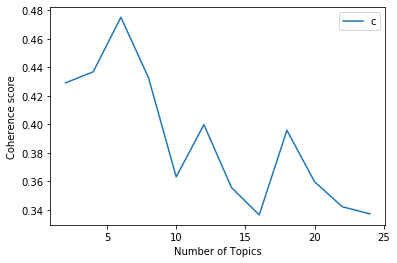

In [83]:
start,stop,step=2,25,2
plot_graph(qs,start,stop,step)

In [85]:
# LSA Model
number_of_topics=6
words=10
model=create_gensim_lsa_model(qs,number_of_topics,words)

Dictionary(32884 unique tokens: ['acute', 'campylobacter', 'cause', 'cefuroxime', 'ciprofloxacin']...)
[(0, '0.230*"blood" + 0.198*"part" + 0.185*"normal" + 0.155*"renal" + 0.141*"treatment" + 0.139*"pain" + 0.124*"diagnosis" + 0.121*"man" + 0.118*"acute" + 0.115*"symptoms"'), (1, '0.364*"left" + 0.339*"right" + 0.248*"nerve" + -0.214*"renal" + -0.214*"blood" + 0.206*"pain" + 0.174*"artery" + -0.134*"serum" + 0.118*"weakness" + -0.117*"glucose"'), (2, '-0.230*"arthritis" + 0.216*"left" + 0.198*"mg" + 0.177*"pressure" + 0.168*"risk" + -0.168*"infection" + 0.164*"heart" + -0.140*"rheumatoid" + 0.139*"blood" + 0.136*"diabetes"'), (3, '-0.615*"renal" + 0.186*"test" + -0.177*"failure" + 0.175*"glucose" + 0.174*"treatment" + 0.140*"risk" + 0.131*"insulin" + -0.128*"left" + -0.123*"hypertension" + -0.123*"blood"'), (4, '0.235*"glucose" + 0.228*"normal" + 0.217*"nerve" + 0.199*"serum" + -0.198*"treatment" + 0.171*"diabetes" + -0.167*"pulmonary" + 0.158*"insulin" + -0.157*"chest" + -0.152*"infe

In [89]:
model[]

<bound method LsiModel.get_topics of <gensim.models.lsimodel.LsiModel object at 0x000002404534ED48>>